In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%reload_ext autoreload
%autoreload 2

In [2]:
from Utils import *
from constants import *

### Scenario Recap

In [ ]:
from Simulation import observe_learned_functions

ecomm3_gpts, ecomm3_gpucb, env = observe_learned_functions()
plot_learned_functions(ecomm3_gpts, ecomm3_gpucb, env)

## Step 3

Experiment n°: 1


n_iteration: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Experiment n°: 2


n_iteration: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


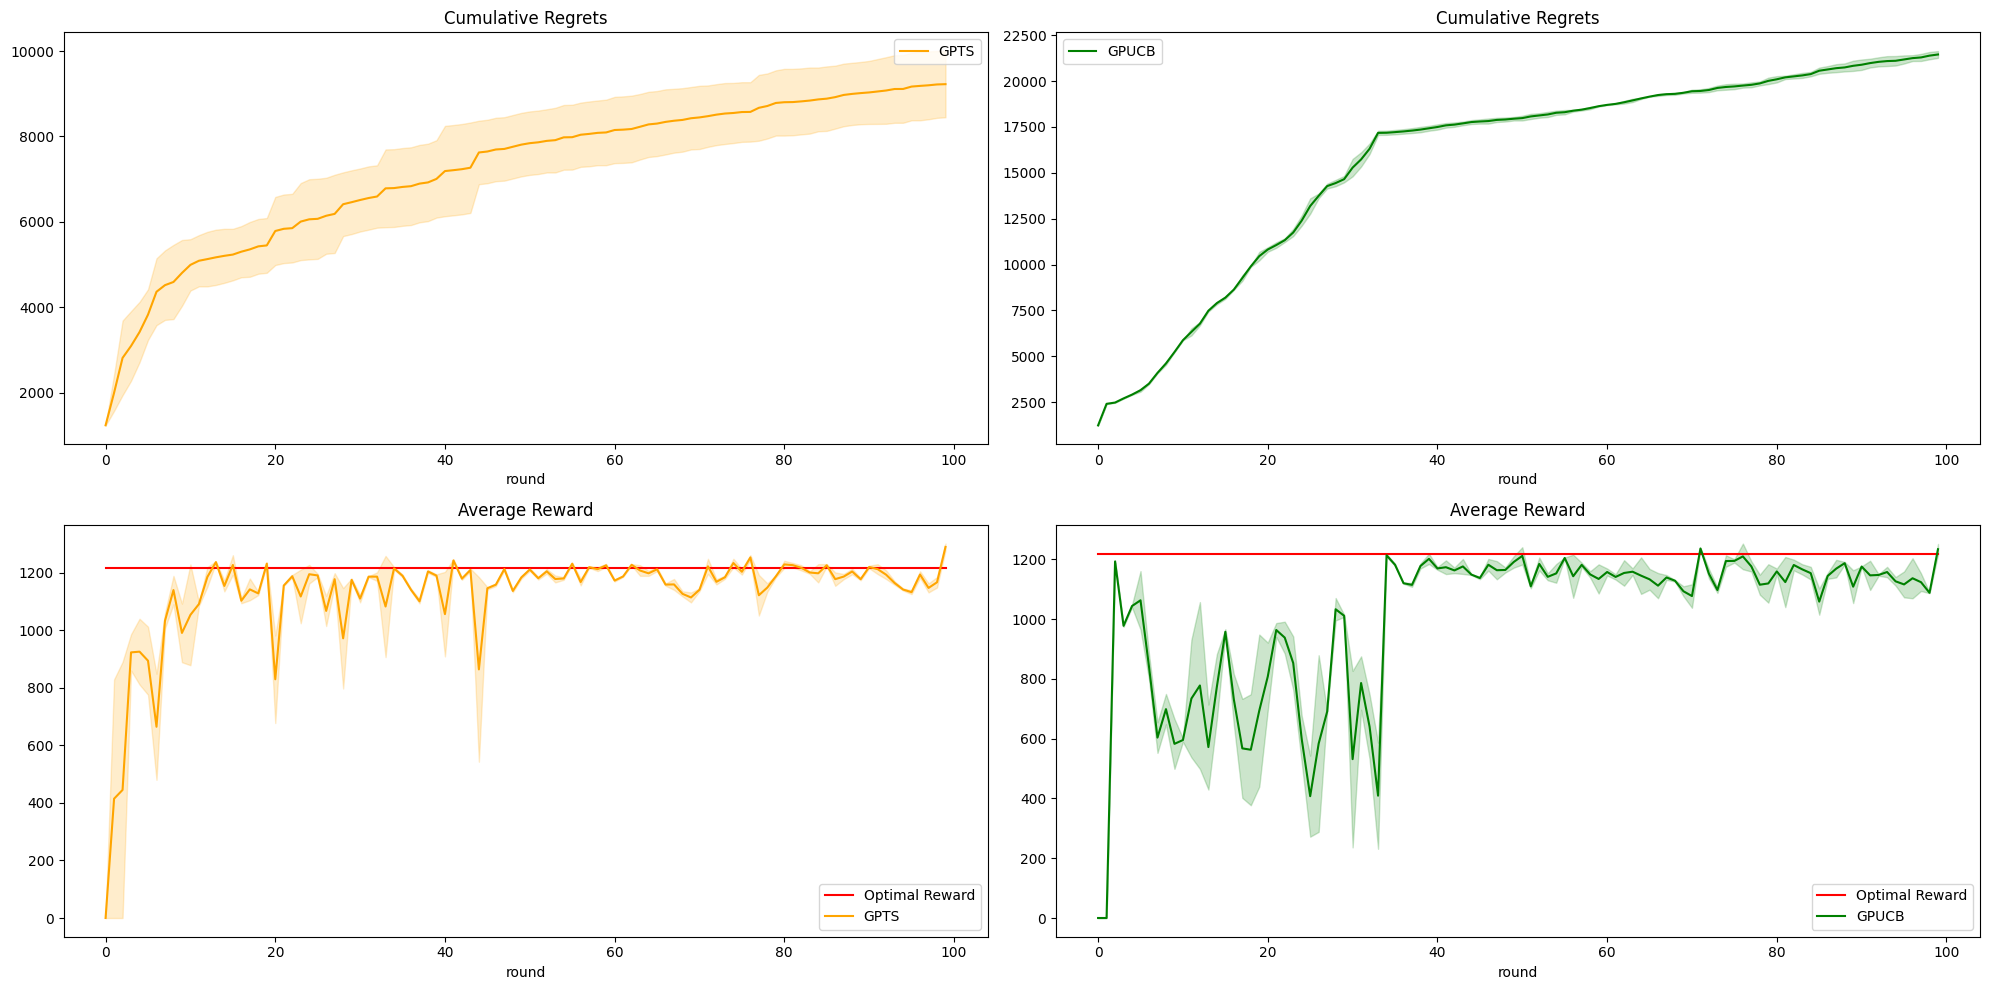

In [3]:
from Simulation import simulate_step3

gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 4

Experiment n°: 1


n_iteration: 100%|██████████| 100/100 [08:28<00:00,  5.09s/it]


Experiment n°: 2


n_iteration: 100%|██████████| 100/100 [09:03<00:00,  5.44s/it]


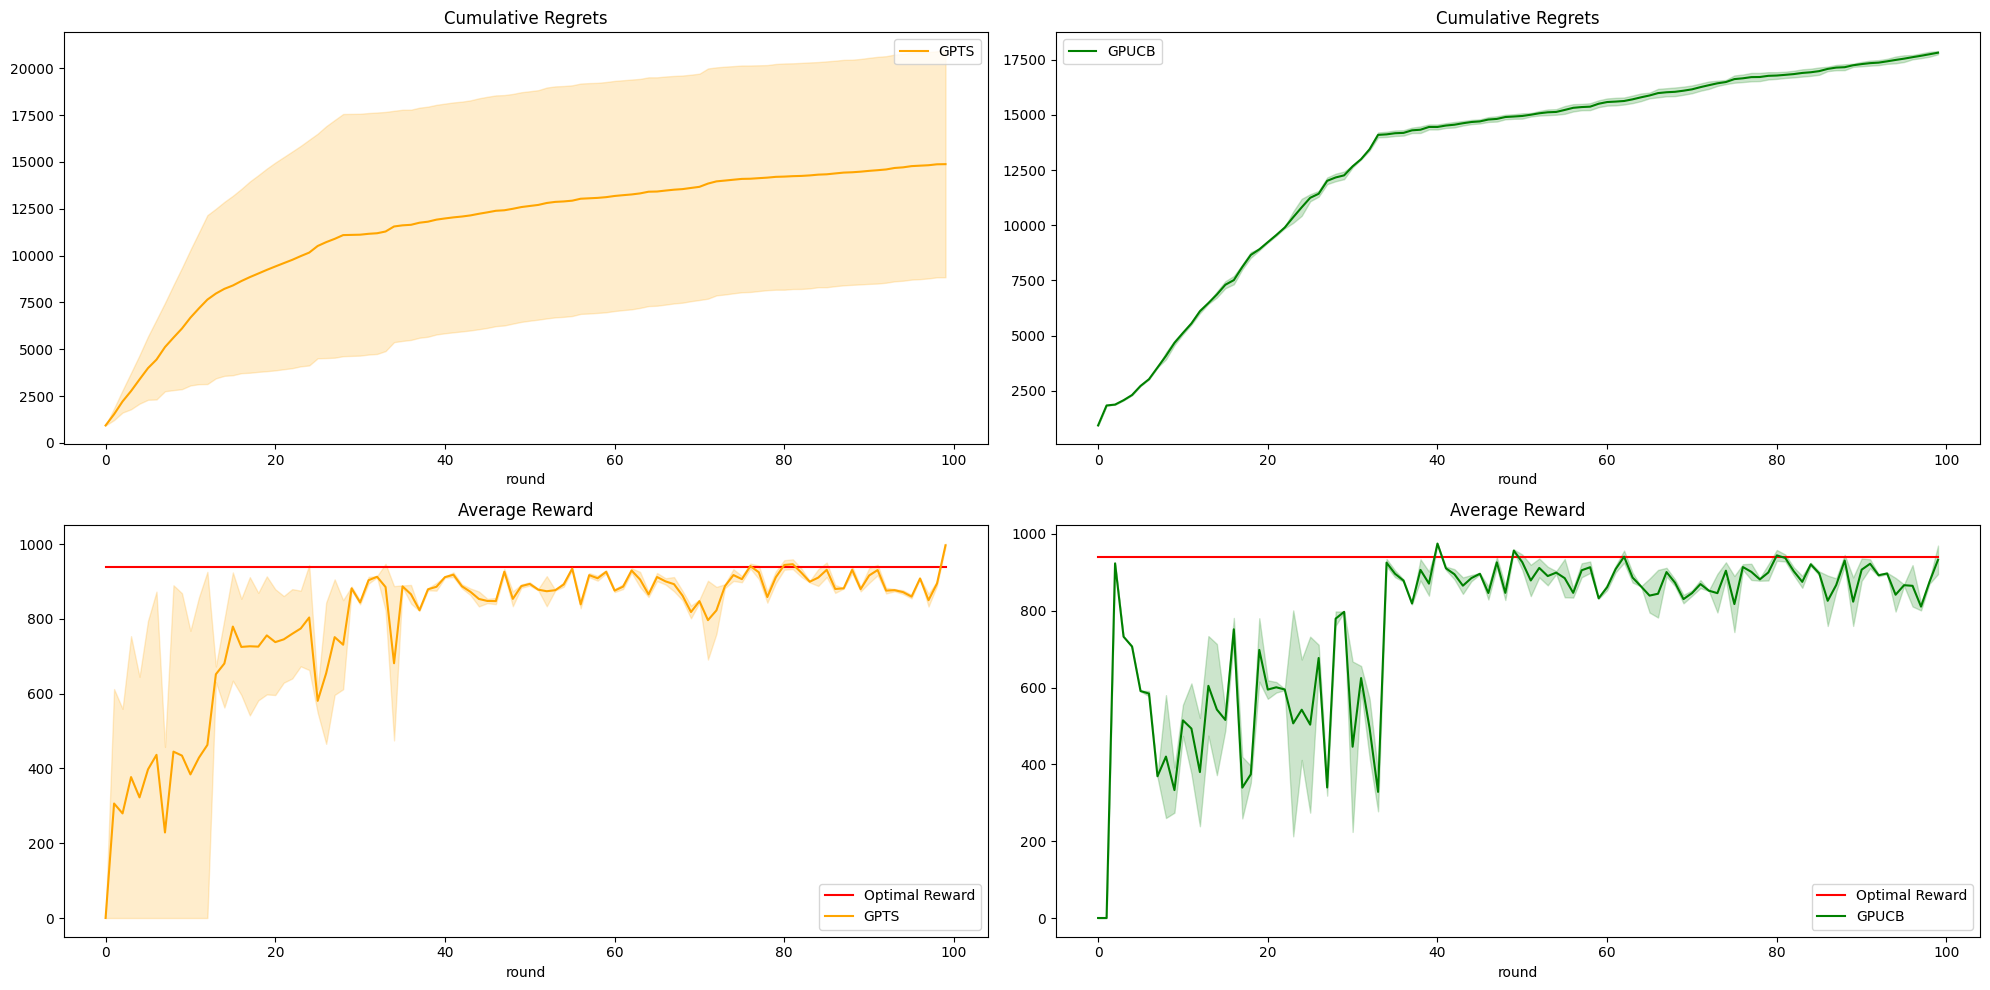

In [3]:
from Simulation import simulate_step4

gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 5

Experiment n°: 1


n_iteration: 100%|██████████| 100/100 [08:10<00:00,  4.90s/it]


Experiment n°: 2


n_iteration: 100%|██████████| 100/100 [08:11<00:00,  4.92s/it]


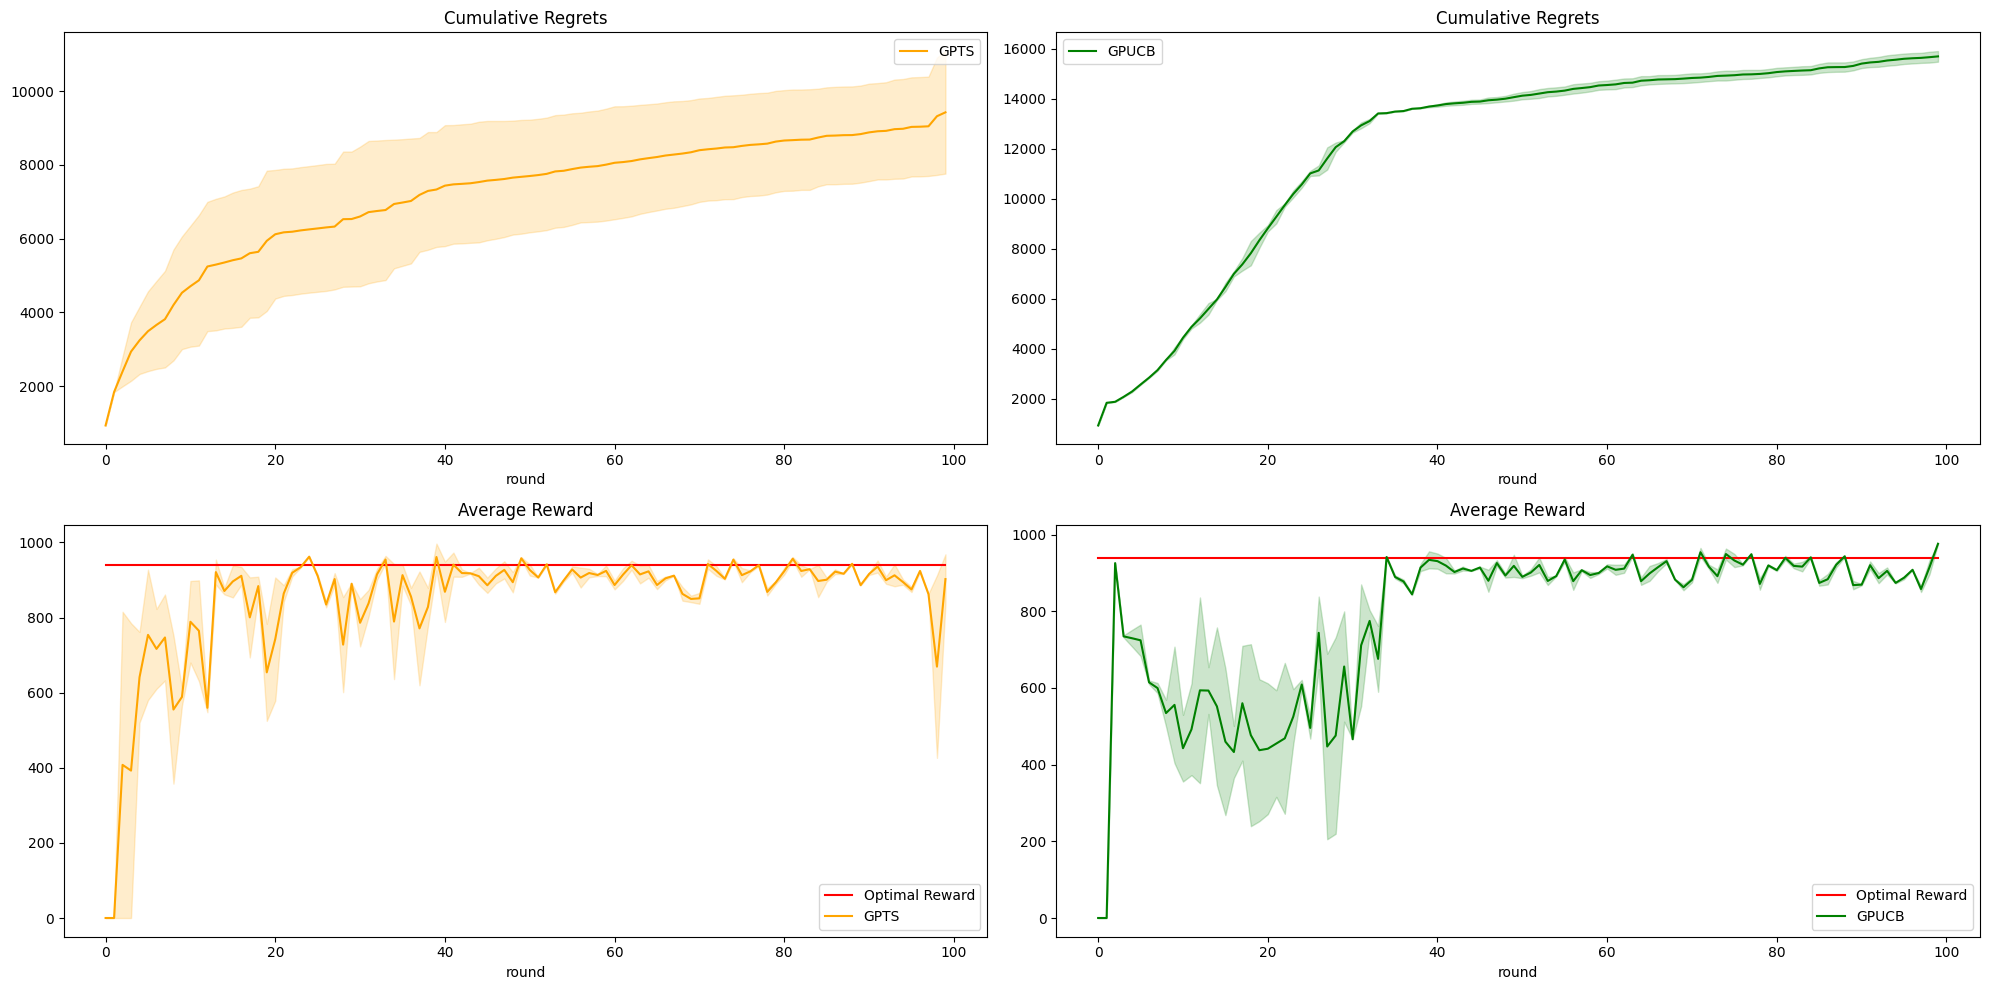

In [3]:
from Simulation import simulate_step5

gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step5()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 6

tau : 51
M, h, eps: 10, 2.0, 0.005;

Experiment n° 1


n_iteration:  43%|████▎     | 91/210 [00:56<01:11,  1.66it/s]

Change detected at time t = 90


n_iteration:  68%|██████▊   | 143/210 [01:27<01:15,  1.13s/it]

Change detected at time t = 142


n_iteration:  93%|█████████▎| 195/210 [01:53<00:07,  2.03it/s]

Change detected at time t = 194


Experiment n° 2


n_iteration:  44%|████▍     | 92/210 [00:54<01:02,  1.88it/s]

Change detected at time t = 91


n_iteration:  68%|██████▊   | 142/210 [01:22<01:35,  1.40s/it]

Change detected at time t = 141


n_iteration:  92%|█████████▏| 193/210 [01:48<00:10,  1.65it/s]

Change detected at time t = 192


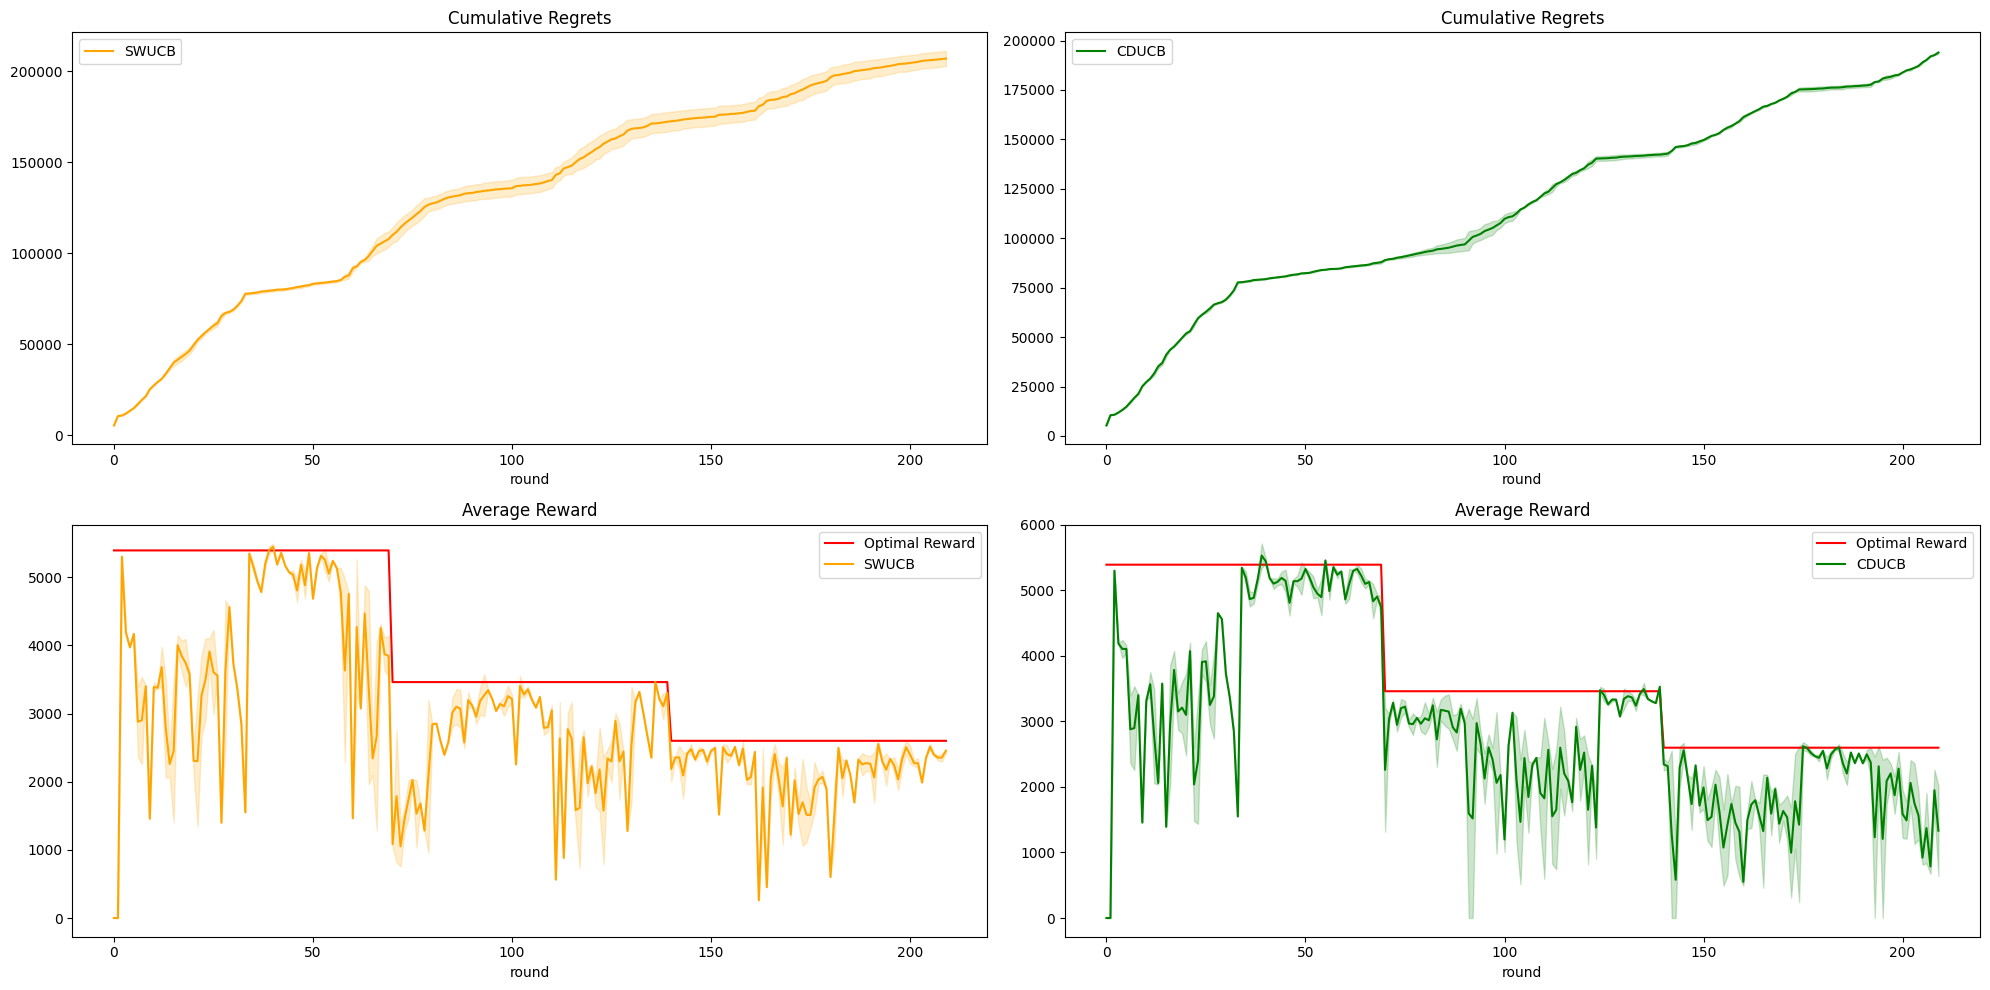

In [9]:
from Simulation import simulate_step6

swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, n_phases, phase_len = simulate_step6()
plot_regrets_step6(swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, ["SWUCB", "CDUCB"], n_phases, phase_len)

## Step 7

In [2]:
from Simulation import simulate_step7

gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step7()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

Experiment n°: 0


n_iteration:  16%|█▌        | 14/90 [00:03<00:21,  3.46it/s]


Evaluating for learner <ContextNode.ContextNode object at 0x7f514064b210>
m_0 = 662.8512262809536
trying:  ['A', 'B'] ['C', 'D']
493.8008827243935 * 0.5 + 435.1193070181355 * 0.5 = 464.46009487126446
trying:  ['A', 'C'] ['B', 'D']
303.3391683073682 * 0.5 + 425.98294486372373 * 0.5 = 364.66105658554596
trying:  ['A', 'D'] ['B', 'C']
435.22812744382514 * 0.5 + 493.8010974642319 * 0.5 = 464.5146124540285
trying:  ['A'] ['B', 'C', 'D']
261.7150757079941 * 0.25 + 673.965092273424 * 0.75 = 570.9025881320665
trying:  ['B'] ['A', 'C', 'D']
324.0266154075876 * 0.25 + 435.7940713179422 * 0.75 = 407.8522073403535
trying:  ['C'] ['A', 'B', 'D']
303.3391683074644 * 0.25 + 633.021355046665 * 0.75 = 550.6008083618648
trying:  ['D'] ['A', 'B', 'C']
204.18592191228512 * 0.25 + 493.60301172825666 * 0.75 = 421.24873927426376


n_iteration:  31%|███       | 28/90 [00:50<00:20,  3.02it/s]


Evaluating for learner <ContextNode.ContextNode object at 0x7f514064b210>
m_0 = 364.7315053324518
trying:  ['A', 'B'] ['C', 'D']
274.88278486090206 * 0.5 + 236.98087861658829 * 0.5 = 255.9318317387452
trying:  ['A', 'C'] ['B', 'D']
155.2199393071999 * 0.5 + 242.12423702132102 * 0.5 = 198.67208816426046
trying:  ['A', 'D'] ['B', 'C']
236.72248835265947 * 0.5 + 274.6210023100528 * 0.5 = 255.67174533135614
trying:  ['A'] ['B', 'C', 'D']
155.22082452625992 * 0.25 + 391.2050235977688 * 0.75 = 332.2089738298916
trying:  ['B'] ['A', 'C', 'D']
162.7640235098385 * 0.25 + 236.77756545816348 * 0.75 = 218.27417997108222
trying:  ['C'] ['A', 'B', 'D']
155.23599204251104 * 0.25 + 392.98429282828596 * 0.75 = 333.5472176318422
trying:  ['D'] ['A', 'B', 'C']
105.37747299676467 * 0.25 + 274.88275764664166 * 0.75 = 232.5064364841724


n_iteration:  47%|████▋     | 42/90 [02:31<00:27,  1.76it/s]


Evaluating for learner <ContextNode.ContextNode object at 0x7f514064b210>
m_0 = 288.9527968602666
trying:  ['A', 'B'] ['C', 'D']
203.85898515896102 * 0.5 + 166.91706585698464 * 0.5 = 185.38802550797283
trying:  ['A', 'C'] ['B', 'D']
94.28594715893001 * 0.5 + 177.4977982562904 * 0.5 = 135.89187270761022
trying:  ['A', 'D'] ['B', 'C']
166.92877312342003 * 0.5 + 204.19658766340908 * 0.5 = 185.56268039341455
trying:  ['A'] ['B', 'C', 'D']
95.98996431454185 * 0.25 + 280.5088434810805 * 0.75 = 234.3791236894458
trying:  ['B'] ['A', 'C', 'D']
114.47154165885037 * 0.25 + 166.92884753513198 * 0.75 = 153.8145210660616
trying:  ['C'] ['A', 'B', 'D']
95.98996443610892 * 0.25 + 280.4986987276791 * 0.75 = 234.37151515478655
trying:  ['D'] ['A', 'B', 'C']


n_iteration:  47%|████▋     | 42/90 [05:10<05:55,  7.40s/it]


KeyboardInterrupt: 

## Hyperparams Tuning

In [ ]:
! python gp_parameter_optimizer.py